# 앙상블

## concatenate
2개 이상의 모델을 합치는 방법을 배울 것임.  
항상 1개의 모델만을 쓴다면 편하겠지만, 데이터 분석쪽 일을 하다보면 앞으로 많은 데이터를 만나게 되고, 순차 모델 하나만으로는 해결할 수 없음.  
이전까지 우리는 컬럼이 여러개인 문제등을 해결해 봄.  
앙상블 장에서는 컬럼 뿐만 아니라 모델도 여러개인 문제를 다룸  

데이터를 준비. x값으로 y 값이 유추되지 않도록 데이터 컬럼을 섞음  
각각 300개의 데이터를 가지고 있는 2개의 x값과 100개의 데이터를 가지고 있는 1개의 y값을 준비함

In [1]:
import numpy as np

# 1. 데이터 준비
x1 = np.array([range(100), range(311, 411), range(100)])
x2 = np.array([range(101, 201), range(311, 411), range(101, 201)])

y = np.array([range(501, 601)])

각 데이터는 3개의 컬럼을 가지고 있음. 

In [8]:
x1 = np.transpose(x1)
x2 = np.transpose(x2)

y = np.transpose(y)

print('x1, x2 shape : ', x1.shape, x2.shape,'\ny shape: ',y.shape)

x1, x2 shape :  (100, 3) (100, 3) 
y shape:  (100, 1)


train, val, test 로 데이터 분리해줌

In [9]:
from sklearn.model_selection import train_test_split
x1_train, x1_test, y_train, t_test = train_test_split(x1, y, test_size=0.4, random_state=66, shuffle=False)
x1_val, x1_test, y_val, y_test = train_test_split(x1_test, t_test, test_size=0.5, random_state=66, shuffle=False)

x2_train, x2_test = train_test_split(x2, test_size=0.4, random_state=66, shuffle=False)
x2_val, x2_test = train_test_split(x2_test, test_size=0.5, random_state=66, shuffle=False)

In [11]:
print("x1 shape(train, val, test) : ", x1_train.shape, x1_val.shape, x1_test.shape)
print("x2 shape(train, val, test) : ", x2_train.shape, x2_val.shape, x2_test.shape)
print("y shape(train, val, test) : ", y_train.shape, y_val.shape, y_test.shape)

x1 shape(train, val, test) :  (60, 3) (20, 3) (20, 3)
x2 shape(train, val, test) :  (60, 3) (20, 3) (20, 3)
y shape(train, val, test) :  (60, 1) (20, 1) (20, 1)


모델을 구성함. 2개의 모델을 만든 뒤 2개의 모델을 병합하는 방식 = 앙상블 모델

In [55]:
# 2. 모델 구성
from keras.models import Sequential, Model
from keras.layers import Dense, Input

# 모델 1
input1 = Input(shape=(3,))
dense1 = Dense(100, activation='relu')(input1)
dense1_2 = Dense(30)(dense1)
dense1_3 = Dense(7)(dense1_2)

# 모델 2
input2 = Input(shape=(3,))
dense2 = Dense(50, activation='relu')(input2)
dense2_1 = Dense(7)(dense2)

중간의 히든 레이어의 깊이는 똑같을 필요가 없음. 이를 도식화 하면 다음과 같음
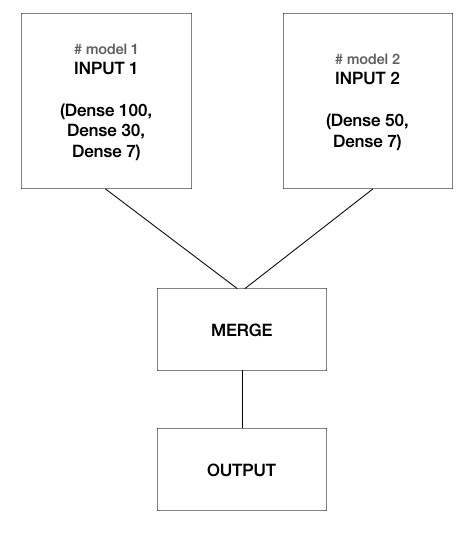
merge 하는 방법은 간단함. `keras.layers.merge` or `keras.layers` 에서 `concatenate` 를 사용하면 됨  
합치려는 모델의 마지막레이어들 리스트 형식으로 전달해주면 됨. `concatenate([model 1의 마지막 레이어, model 2의 마지막 레이어]`  
Concatenate() 도 존재 ()붙여 사용하면 됨.

In [56]:
from keras.layers.merge import concatenate
merge1 = concatenate([dense1_3, dense2_1])

병합된 이후에는 앞에서 했던 것처럼 함수형으로 모델을 이어나가면 됨. 

In [57]:
model1 = Dense(10)(merge1)
model2 = Dense(5)(model1)
output = Dense(1)(model2)

output 레이어까지 준비가 되었으니, `Model()`을 사용하여 모델들을 정의해봄. 

In [58]:
model = Model(inputs = [input1, input2], outputs=output)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_67 (Dense)                (None, 100)          400         input_29[0][0]                   
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_68 (Dense)                (None, 30)           3030        dense_67[0][0]                   
___________________________________________________________________________________________

다섯번째 dense와 여섯번째 dense 사이에서 concatenate 가 잘 이루어진 것을 확인  
훈련을 진행함.  
훈련을 할때 `x`의 입력데이터가 2개 이므로 list 형태를 취하여 들어가야함. `validation_data` 도 마찬가지로 2개의 데이터이므로 리스트 형태로

In [59]:
# 3. 훈련 
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.fit([x1_train, x2_train], y_train, batch_size=1, epochs=300, validation_data=([x1_val, x2_val], y_val))

Epoch 1/300
60/60 [==============================] - 0s 3ms/step - loss: 108147.2577 - mse: 108147.2577 - val_loss: 70.0662 - val_mse: 70.0662
Epoch 2/300
60/60 [==============================] - 0s 1ms/step - loss: 245.9274 - mse: 245.9274 - val_loss: 344.8391 - val_mse: 344.8391
Epoch 3/300
60/60 [==============================] - 0s 1ms/step - loss: 62.1775 - mse: 62.1775 - val_loss: 105.4446 - val_mse: 105.4446
Epoch 4/300
60/60 [==============================] - 0s 1ms/step - loss: 21.1234 - mse: 21.1234 - val_loss: 1.2421 - val_mse: 1.2421
Epoch 5/300
60/60 [==============================] - 0s 1ms/step - loss: 8.7383 - mse: 8.7383 - val_loss: 1.3765 - val_mse: 1.3765
Epoch 6/300
60/60 [==============================] - 0s 1ms/step - loss: 0.6959 - mse: 0.6959 - val_loss: 1.0329 - val_mse: 1.0329
Epoch 7/300
60/60 [==============================] - 0s 1ms/step - loss: 0.5291 - mse: 0.5291 - val_loss: 1.3514 - val_mse: 1.3514
Epoch 8/300
60/60 [==============================] - 0s

Epoch 63/300
60/60 [==============================] - 0s 1ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 64/300
60/60 [==============================] - 0s 1ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 65/300
60/60 [==============================] - 0s 1ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 66/300
60/60 [==============================] - 0s 1ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 67/300
60/60 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0709 - val_mse: 0.0709
Epoch 68/300
60/60 [==============================] - 0s 1ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0452 - val_mse: 0.0452
Epoch 69/300
60/60 [==============================] - 0s 1ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 70/300
60/60 [==============================] - 0s 1ms/step - loss: 0.

60/60 [==============================] - 0s 1ms/step - loss: 0.2062 - mse: 0.2062 - val_loss: 0.4534 - val_mse: 0.4534
Epoch 125/300
60/60 [==============================] - 0s 1ms/step - loss: 0.1981 - mse: 0.1981 - val_loss: 0.4368 - val_mse: 0.4368
Epoch 126/300
60/60 [==============================] - 0s 1ms/step - loss: 0.7607 - mse: 0.7607 - val_loss: 35.2753 - val_mse: 35.2753
Epoch 127/300
60/60 [==============================] - 0s 1ms/step - loss: 4.9583 - mse: 4.9583 - val_loss: 0.0392 - val_mse: 0.0392
Epoch 128/300
60/60 [==============================] - 0s 1ms/step - loss: 0.3551 - mse: 0.3551 - val_loss: 1.5447 - val_mse: 1.5447
Epoch 129/300
60/60 [==============================] - 0s 1ms/step - loss: 0.7699 - mse: 0.7699 - val_loss: 0.1851 - val_mse: 0.1851
Epoch 130/300
60/60 [==============================] - 0s 1ms/step - loss: 0.2164 - mse: 0.2164 - val_loss: 0.3074 - val_mse: 0.3074
Epoch 131/300
60/60 [==============================] - 0s 1ms/step - loss: 0.2280

60/60 [==============================] - 0s 1ms/step - loss: 0.2793 - mse: 0.2793 - val_loss: 0.1535 - val_mse: 0.1535
Epoch 184/300
60/60 [==============================] - 0s 1ms/step - loss: 0.1741 - mse: 0.1741 - val_loss: 0.8969 - val_mse: 0.8969
Epoch 185/300
60/60 [==============================] - 0s 1ms/step - loss: 0.2803 - mse: 0.2803 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 186/300
60/60 [==============================] - 0s 1ms/step - loss: 0.1195 - mse: 0.1195 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 187/300
60/60 [==============================] - 0s 1ms/step - loss: 0.0560 - mse: 0.0560 - val_loss: 0.1277 - val_mse: 0.1277
Epoch 188/300
60/60 [==============================] - 0s 1ms/step - loss: 0.0608 - mse: 0.0608 - val_loss: 0.1855 - val_mse: 0.1855
Epoch 189/300
60/60 [==============================] - 0s 1ms/step - loss: 0.1376 - mse: 0.1376 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 190/300
60/60 [==============================] - 0s 1ms/step - loss: 0.0433 -

Epoch 244/300
60/60 [==============================] - 0s 1ms/step - loss: 0.2750 - mse: 0.2750 - val_loss: 0.1567 - val_mse: 0.1567
Epoch 245/300
60/60 [==============================] - 0s 1ms/step - loss: 0.2588 - mse: 0.2588 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 246/300
60/60 [==============================] - 0s 1ms/step - loss: 0.2927 - mse: 0.2927 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 247/300
60/60 [==============================] - 0s 1ms/step - loss: 0.0699 - mse: 0.0699 - val_loss: 0.1755 - val_mse: 0.1755
Epoch 248/300
60/60 [==============================] - 0s 1ms/step - loss: 0.2753 - mse: 0.2753 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 249/300
60/60 [==============================] - 0s 1ms/step - loss: 0.1981 - mse: 0.1981 - val_loss: 1.2100 - val_mse: 1.2100
Epoch 250/300
60/60 [==============================] - 0s 1ms/step - loss: 0.2938 - mse: 0.2938 - val_loss: 0.0823 - val_mse: 0.0823
Epoch 251/300
60/60 [==============================] - 0s 1ms/step - 

`evaluate` 에서도 x의 입력데이터가 2개 이므로 list의 형태를 취해서 들어가야 함.

In [60]:
mse = model.evaluate([x1_test, x2_test], y_test, batch_size=1)
print('mse : ', mse)

20/20 [==============================] - 0s 655us/step - loss: 0.2494 - mse: 0.2494
mse :  [0.24938639998435974, 0.24938639998435974]


`predict` 에서도 x의 입력데이터가 2개 이므로 list의 형태를 취해서 들어가야 함.

In [61]:
y_predict = model.predict([x1_test, x2_test])

print(y_predict.shape)
for i in range(len(y_predict)):
    print('실제 값 : ', y_test[i], '모델 예측 값 : ', y_predict[i])

(20, 1)
실제 값 :  [581] 모델 예측 값 :  [581.1665]
실제 값 :  [582] 모델 예측 값 :  [582.16876]
실제 값 :  [583] 모델 예측 값 :  [583.1712]
실제 값 :  [584] 모델 예측 값 :  [584.17365]
실제 값 :  [585] 모델 예측 값 :  [585.1761]
실제 값 :  [586] 모델 예측 값 :  [586.17847]
실제 값 :  [587] 모델 예측 값 :  [587.1809]
실제 값 :  [588] 모델 예측 값 :  [588.18335]
실제 값 :  [589] 모델 예측 값 :  [589.19604]
실제 값 :  [590] 모델 예측 값 :  [590.21606]
실제 값 :  [591] 모델 예측 값 :  [591.2345]
실제 값 :  [592] 모델 예측 값 :  [592.25305]
실제 값 :  [593] 모델 예측 값 :  [593.35034]
실제 값 :  [594] 모델 예측 값 :  [594.4546]
실제 값 :  [595] 모델 예측 값 :  [595.55865]
실제 값 :  [596] 모델 예측 값 :  [596.6626]
실제 값 :  [597] 모델 예측 값 :  [597.76654]
실제 값 :  [598] 모델 예측 값 :  [598.87054]
실제 값 :  [599] 모델 예측 값 :  [599.97455]
실제 값 :  [600] 모델 예측 값 :  [601.0785]


## Merge Layer
concatenate는 단순하게 모델 2개를 엮어주는 역할을 합니다.  
인풋이 (10, 3) 인 모델 1과, 모델 2을 엮을 경우 concatenate 시점에서는 (10, 6)으로 연결되게 됨. 합쳐지는 레이어에서 노드들이 단순히 연결하는 역할  
아래 나오는 함수들은 더하거나, 빼거나, 평균을 내는 방식으로 합쳐주는 방식

### Add
keras.layers.Add()  
layers 끼리 단순한 더하여 합치는 레이어, 동일한 모양의 텐서 목록을 입력으로 사용(더하고자 하는 layers의 노드 수가 같아야 함.)하고 하나의 텐서(입력의 노드수과 같은 shape)를 반환함.

In [46]:
from keras.layers.merge import Add

input1 = Input(shape=(16,))
x1 = Dense(8, activation='relu')(input1)

input2 = Input(shape=(32,))
x2 = Dense(8, activation='relu')(input2)

added = Add()([x1, x2])
out = Dense(4)(added)

model = Model(inputs=[input1, input2], outputs=out)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 8)            136         input_17[0][0]                   
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 8)            264         input_18[0][0]                   
____________________________________________________________________________________________

### Subtract
keras.layers.Subtract()  
layers 끼리 단순한 뺄셈하여 합치는 레이어, 동일한 모양의 크기 2인 텐서 목록을 사용하고 동일한 모양의 단일 텐서(입력[0]-입력[1])를 반환함. 

In [50]:
from keras.layers.merge import Add, Subtract

input1 = Input(shape=(16,))
x1 = Dense(8, activation='relu')(input1)

input2 = Input(shape=(32,))
x2 = Dense(8, activation='relu')(input2)

subtracted = Subtract()([x1, x2])
out = Dense(4)(subtracted)

model = Model(inputs=[input1, input2], outputs=out)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 8)            136         input_25[0][0]                   
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 8)            264         input_26[0][0]                   
____________________________________________________________________________________________

### Multiply
keras.layers.Mulitply()  
layers 끼리 입력 목록을 요소별로 곱하여 합치는 레이어  
* 동일한 shape을 받고(마지막 레이어의 output shape, 노드수가 같아야함.)  
* 하나의 텐서를 반환함.

### Average
keras.layers.Average()  
layers 끼리 입력 목록의 평균으로 합쳐지는 레이어  
* 동일한 shape을 받고(마지막 레이어의 output shape, 노드수가 같아야함.)  
* 하나의 텐서를 반환함.

### Minimum
keras.layers.Minimum()  
layers 끼리 입력 목록의 최소로 계산하는 레이어  
* 동일한 shape을 받고(마지막 레이어의 output shape, 노드수가 같아야함.)  
* 하나의 텐서를 반환함.

### Concatenate
keras.layers.Concatenate(axis=-1)  
입력 목록을 연결하는 계층, 
* 입력 목록을 연결해서
* 하나의 텐서로 반환함.

### Dot
keras.layers.Dot()  
두 텐서간 내적을 계산하는 레이어,  
* input으로 (batch_size, n)인 a, b에 적용되는 경우 ->
* (batch_size, 1) 로 출력함

위의 함수들과 똑같이 소문자로 함수가 존재함. 내용은 같으나 사용방법만 달라 유의하고 넘어가면 됨.  
* Concatenate()([x1, x2])
* concatenate([x1, x2])